![alt text](image.png)

Open a GeoTIFF File

Pick any .tif file (you can use one from your dataset):

In [21]:
import rasterio
from rasterio.plot import show
import os
import matplotlib.pyplot as plt
# Example: pick first image from one class
dataset_path = r"D:\Database\EuoroSat\EuroSATallBands"
sample_class = os.listdir(dataset_path)[0]
sample_image = os.path.join(dataset_path, sample_class, os.listdir(os.path.join(dataset_path, sample_class))[0])

# Open the GeoTIFF
with rasterio.open(sample_image) as src:
    print("File:", sample_image)
    print("Driver:", src.driver)
    print("CRS:", src.crs)
    print("Width, Height:", src.width, src.height)
    print("Number of Bands:", src.count)
    print("Bounds:", src.bounds)
    print("Transform:", src.transform)
    print("Resolution:", src.res)
    print("Data Type:", src.dtypes)

File: D:\Database\EuoroSat\EuroSATallBands\AnnualCrop\AnnualCrop_1.tif
Driver: GTiff
CRS: EPSG:32635
Width, Height: 64 64
Number of Bands: 13
Bounds: BoundingBox(left=624602.2348443292, bottom=4876646.411998601, right=625242.6000851066, top=4877286.033637)
Transform: | 10.01, 0.00, 624602.23|
| 0.00,-9.99, 4877286.03|
| 0.00, 0.00, 1.00|
Resolution: (10.00570688714736, 9.994088099999352)
Data Type: ('uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16')


Extract Pixel-to-Geolocation Mapping

Each pixel can be converted to its real-world coordinates using the affine transform.

In [22]:
from rasterio.transform import xy

with rasterio.open(sample_image) as src:
    row, col = 50, 50  # example pixel
    x, y = xy(src.transform, row, col)
    print(f"Pixel ({row},{col}) -> Geographic Coordinate: ({x:.2f}, {y:.2f})")

Pixel (50,50) -> Geographic Coordinate: (625107.52, 4876781.33)


Access the Metadata Dictionary

You can inspect all metadata fields (e.g., acquisition date, satellite ID, etc. — if stored):

In [23]:
with rasterio.open(sample_image) as src:
    meta = src.meta
    tags = src.tags()
    
print("Metadata summary:\n", meta)
print("\nExtra tags:\n", tags)


Metadata summary:
 {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 64, 'height': 64, 'count': 13, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 35N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",27],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32635"]]'), 'transform': Affine(10.00570688714736, 0.0, 624602.2348443292,
       0.0, -9.994088099999352, 4877286.033637)}

Extra tags:
 {'AREA_OR_POINT': 'Area'}


Plot the Raster with Metadata

You can visualize both image and its bounds:

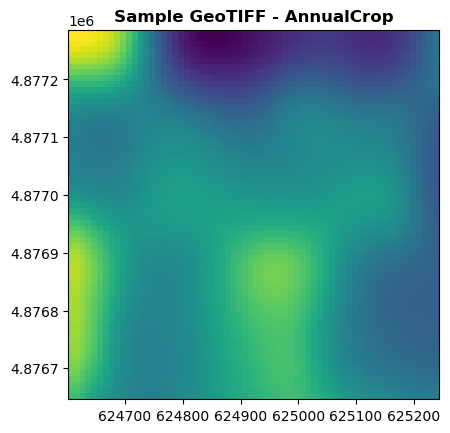

<Figure size 500x500 with 0 Axes>

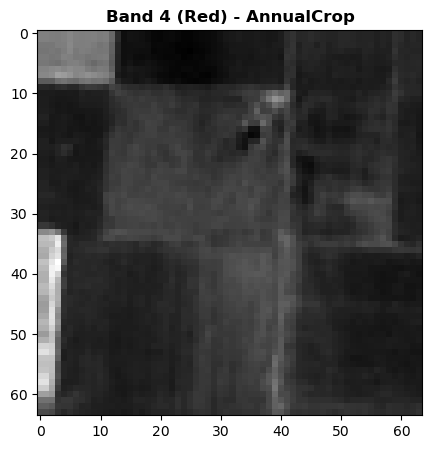

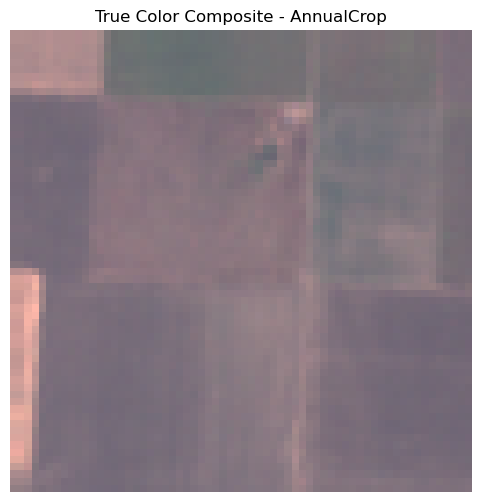

In [27]:
with rasterio.open(sample_image) as src:
    show(src,title=f"Sample GeoTIFF - {sample_class}")
    plt.figure(figsize=(5,5))
    plt.show(src)
    
#Displaying one spectral band (e.g., B4 – red band or B8 – NIR):
with rasterio.open(sample_image) as src:
    plt.figure(figsize=(5,5))
    show(src.read(4), title=f"Band 4 (Red) - {sample_class}", cmap='gray')
    
#Use Bands 4 (Red), 3 (Green), 2 (Blue) to create an RGB visualization.
with rasterio.open(sample_image) as src:
    # Read RGB bands
    rgb = src.read([4, 3, 2])
    
    # Normalize to [0,1]
    rgb = rgb.astype(float)
    rgb = rgb / rgb.max()
    
    plt.figure(figsize=(6,6))
    plt.imshow(rgb.transpose(1, 2, 0))
    plt.title(f"True Color Composite - {sample_class}")
    plt.axis('off')
    plt.show()

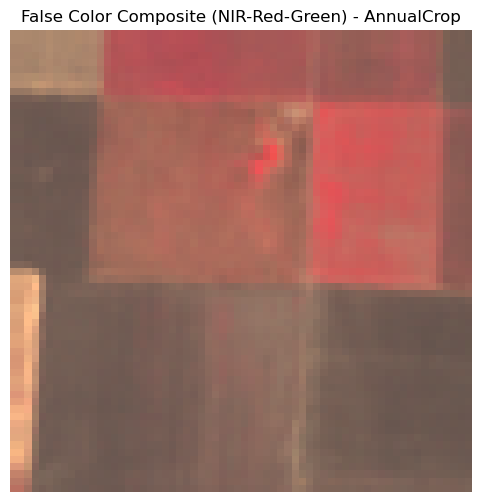

In [ ]:
#Bands 8 (NIR), 4 (Red), 3 (Green) — this emphasizes vegetation (bright red areas).You’ll now see vegetation glowing red , urban areas gray, and water dark — a strong indicator that the plot works.
with rasterio.open(sample_image) as src:
    nir_red_green = src.read([8, 4, 3]).astype(float)
    nir_red_green /= nir_red_green.max()
    plt.figure(figsize=(6,6))
    plt.imshow(nir_red_green.transpose(1,2,0))
    plt.title(f"False Color Composite (NIR-Red-Green) - {sample_class}")
    plt.axis('off')
    plt.show()

Combine Metadata into a Table (for Many Files)

To explore all geospatial extents or CRS across your dataset:

In [29]:
import pandas as pd

geo_info = []
for label in os.listdir(dataset_path):
    folder = os.path.join(dataset_path, label)
    for f in os.listdir(folder):
        if f.endswith('.tif'):
            path = os.path.join(folder, f)
            with rasterio.open(path) as src:
                geo_info.append({
                    'class': label,
                    'filename': f,
                    'crs': src.crs,
                    'width': src.width,
                    'height': src.height,
                    'res_x': src.res[0],
                    'res_y': src.res[1],
                    'xmin': src.bounds.left,
                    'ymin': src.bounds.bottom,
                    'xmax': src.bounds.right,
                    'ymax': src.bounds.top
                })
geo_df = pd.DataFrame(geo_info)
display(geo_df.head())

,class,filename,crs,width,height,res_x,res_y,xmin,ymin,xmax,ymax
0,AnnualCrop,AnnualCrop_1.tif,"(proj, zone, datum, units, no_defs)",64,64,10.005707,9.994088,624602.234844,4.876646e+06,625242.600085,4.877286e+06
1,AnnualCrop,AnnualCrop_10.tif,"(proj, zone, datum, units, no_defs)",64,64,10.000264,9.999233,600895.002182,4.326630e+06,601535.019070,4.327270e+06
2,AnnualCrop,AnnualCrop_100.tif,"(proj, zone, datum, units, no_defs)",64,64,9.996100,10.005846,590396.585648,5.425352e+06,591036.336018,5.425992e+06
3,AnnualCrop,AnnualCrop_1000.tif,"(proj, zone, datum, units, no_defs)",64,64,10.000575,10.009885,579566.972288,5.415770e+06,580207.009118,5.416411e+06
4,AnnualCrop,AnnualCrop_1001.tif,"(proj, zone, datum, units, no_defs)",64,64,10.008549,10.021689,712227.571466,5.746628e+06,712868.118611,5.747269e+06


In [30]:
#Test the characteristics of the resulting data
geo_df.shape
geo_df.info()
geo_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27597 entries, 0 to 27596
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   class     27597 non-null  object 
 1   filename  27597 non-null  object 
 2   crs       27597 non-null  object 
 3   width     27597 non-null  int64  
 4   height    27597 non-null  int64  
 5   res_x     27597 non-null  float64
 6   res_y     27597 non-null  float64
 7   xmin      27597 non-null  float64
 8   ymin      27597 non-null  float64
 9   xmax      27597 non-null  float64
 10  ymax      27597 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 2.3+ MB


,width,height,res_x,res_y,xmin,ymin,xmax,ymax
count,27597.0,27597.0,27597.000000,27597.000000,27597.000000,2.759700e+04,27597.000000,2.759700e+04
mean,64.0,64.0,9.999903,9.999873,554328.699952,5.403652e+06,554968.693729,5.404292e+06
std,0.0,0.0,0.017907,0.018326,127552.152753,8.696226e+05,127552.160649,8.696226e+05
min,64.0,64.0,9.923678,9.924178,199979.999963,2.099360e+06,200620.000000,2.100000e+06
25%,64.0,64.0,9.994127,9.993586,456007.482117,4.858163e+06,456648.158212,4.858804e+06
50%,64.0,64.0,10.000000,10.000000,569199.848943,5.411212e+06,569839.978760,5.411852e+06
75%,64.0,64.0,10.005797,10.006072,655718.151300,5.808623e+06,656359.875051,5.809266e+06
max,64.0,64.0,10.076585,10.073538,809079.149412,9.399360e+06,809719.324418,9.400000e+06


Understanding Sentinel-2 Bands

Sentinel-2 provides 13 spectral bands (though EuroSAT typically uses 10).
Each band captures reflectance at a specific wavelength, revealing different land surface properties:

| **Band** | **Name**                    | **Center Wavelength (µm)** | **Resolution (m)** | **Main Uses / Land Type Sensitivity**                           |
| -------- | --------------------------- | -------------------------- | ------------------ | --------------------------------------------------------------- |
| **B1**   | Coastal Aerosol             | 0.443                      | 60                 | Detecting atmospheric particles, coastal and aerosol correction |
| **B2**   | Blue                        | 0.490                      | 10                 | Water bodies, bathymetry, distinguishing soil vs vegetation     |
| **B3**   | Green                       | 0.560                      | 10                 | Vegetation vigor, water turbidity, built-up area contrast       |
| **B4**   | Red                         | 0.665                      | 10                 | Chlorophyll absorption; used in NDVI (vegetation index)         |
| **B5**   | Red Edge 1                  | 0.705                      | 20                 | Sensitive to chlorophyll content and plant stress               |
| **B6**   | Red Edge 2                  | 0.740                      | 20                 | Vegetation monitoring; differentiating crop types               |
| **B7**   | Red Edge 3                  | 0.783                      | 20                 | Vegetation structure, canopy density                            |
| **B8**   | Near Infrared (NIR)         | 0.842                      | 10                 | Biomass, vegetation vigor, used in NDVI                         |
| **B8A**  | Narrow NIR                  | 0.865                      | 20                 | Subtle vegetation and moisture differences                      |
| **B9**   | Water Vapor                 | 0.945                      | 60                 | Atmospheric correction, water vapor detection                   |
| **B10**  | Cirrus                      | 1.375                      | 60                 | Cloud detection (cirrus and thin clouds)                        |
| **B11**  | SWIR 1 (Shortwave Infrared) | 1.610                      | 20                 | Built-up area detection (NDBI), soil and moisture content       |
| **B12**  | SWIR 2 (Shortwave Infrared) | 2.190                      | 20                 | Burned area detection, snow/ice, mineral content                |



In [ ]:
# ===============================================================
# 📊 EuroSAT Sentinel-2 Multispectral Dataset EDA
# Purpose: Explore bands, statistics, correlations & PCA
# ===============================================================

import os
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# ---------------------------------------------------------------
# Dataset Path
# ---------------------------------------------------------------
dataset_path = r"D:\Database\EuoroSat\EuroSATallBands"

classes = sorted(os.listdir(dataset_path))
print("Classes found:", classes)
print("Number of classes:", len(classes))

# Count number of images per class
image_counts = {}
for c in classes:
    folder = os.path.join(dataset_path, c)
    images = [f for f in os.listdir(folder) if f.endswith('.tif')]
    image_counts[c] = len(images)

df_counts = pd.DataFrame.from_dict(image_counts, orient='index', columns=['num_images'])
display(df_counts)


Classes found: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Number of classes: 10


,num_images
AnnualCrop,3000
Forest,3000
HerbaceousVegetation,3000
Highway,2500
Industrial,2500
Pasture,2000
PermanentCrop,2500
Residential,3000
River,2500
SeaLake,3597



Sample image info:
Shape (bands, height, width): (13, 64, 64)
CRS: EPSG:32635
Data type: ('uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16')
Bounds: BoundingBox(left=624602.2348443292, bottom=4876646.411998601, right=625242.6000851066, top=4877286.033637)


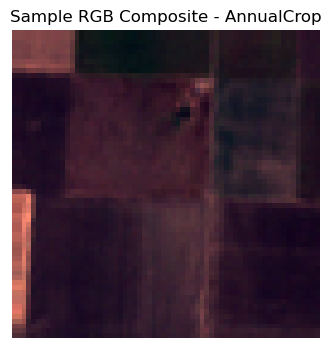

In [ ]:
# ---------------------------------------------------------------
# Explore one sample image
# ---------------------------------------------------------------
sample_class = classes[0]
sample_image = os.path.join(dataset_path, sample_class, os.listdir(os.path.join(dataset_path, sample_class))[0])

with rasterio.open(sample_image) as src:
    arr = src.read()
    print("\nSample image info:")
    print(f"Shape (bands, height, width): {arr.shape}")
    print(f"CRS: {src.crs}")
    print(f"Data type: {src.dtypes}")
    print(f"Bounds: {src.bounds}")

# Show RGB visualization if bands 4,3,2 exist
if arr.shape[0] >= 4:
    rgb = np.stack([arr[3], arr[2], arr[1]], axis=-1)
    rgb = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb))
    plt.figure(figsize=(4,4))
    plt.imshow(rgb)
    plt.title(f"Sample RGB Composite - {sample_class}")
    plt.axis('off')
    plt.show()


In [12]:

# ---------------------------------------------------------------
# Band statistics for each class (mean & std)
# ---------------------------------------------------------------
stats = []

for label in tqdm(classes, desc="Computing stats"):
    folder = os.path.join(dataset_path, label)
    image_files = [f for f in os.listdir(folder) if f.endswith('.tif')]
    for f in image_files[:50]:  # sample first 50 images per class
        with rasterio.open(os.path.join(folder, f)) as src:
            arr = src.read().astype(np.float32)
            band_means = arr.reshape(arr.shape[0], -1).mean(axis=1)
            band_stds = arr.reshape(arr.shape[0], -1).std(axis=1)
            stats.append([label] + list(band_means) + list(band_stds))

num_bands = arr.shape[0]
columns = (
    ['class'] +
    [f'B{i}_mean' for i in range(1, num_bands+1)] +
    [f'B{i}_std' for i in range(1, num_bands+1)]
)
df_stats = pd.DataFrame(stats, columns=columns)
display(df_stats.head())

Computing stats: 100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


,class,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,B8_mean,B9_mean,...,B4_std,B5_std,B6_std,B7_std,B8_std,B9_std,B10_std,B11_std,B12_std,B13_std
0,AnnualCrop,1323.202637,1124.514648,1044.731934,1169.281494,1291.627197,1553.754883,1765.669434,1748.955322,484.055908,...,173.940887,172.792877,302.143127,368.982819,396.474792,79.425240,0.992652,257.534576,257.585480,435.588745
1,AnnualCrop,1187.089844,1017.638428,1143.992188,1074.077637,1594.368896,3338.721436,4063.268555,3999.760742,1782.841797,...,641.071350,480.814026,678.580566,1002.137024,977.365601,238.683807,3.647513,1204.149536,1166.637817,984.861145
2,AnnualCrop,1613.533936,1543.559082,1612.584961,1922.695312,2114.679688,2631.855713,3002.193359,2893.610352,700.943604,...,415.337463,265.064697,283.830536,435.637054,433.165710,44.192402,1.213166,590.316956,594.045044,438.829865
3,AnnualCrop,1546.874268,1442.861328,1532.079834,1649.649414,1966.929443,3062.829590,3540.499023,3381.061279,771.992432,...,645.123535,470.995056,405.647583,609.864075,576.534729,76.195114,1.888189,905.582458,910.957886,606.568665
4,AnnualCrop,1508.039551,1290.349121,1242.706299,1258.629639,1502.869629,2493.611084,3081.958252,2964.619873,930.400879,...,455.828064,336.213257,346.111237,660.872437,712.115112,116.656204,1.293658,595.167542,804.086426,691.635925


,Band,Mean Reflectance,Std Dev Reflectance
0,B1,1377.544800,67.960983
1,B2,1139.946289,156.994003
2,B3,1054.232300,189.921036
3,B4,946.001038,283.943970
4,B5,1204.288940,231.077911
5,B6,2060.961914,357.306061
6,B7,2449.200195,461.661316
7,B8,2371.555908,538.280762
8,B9,768.482239,97.496956
9,B10,23.908699,1.258833


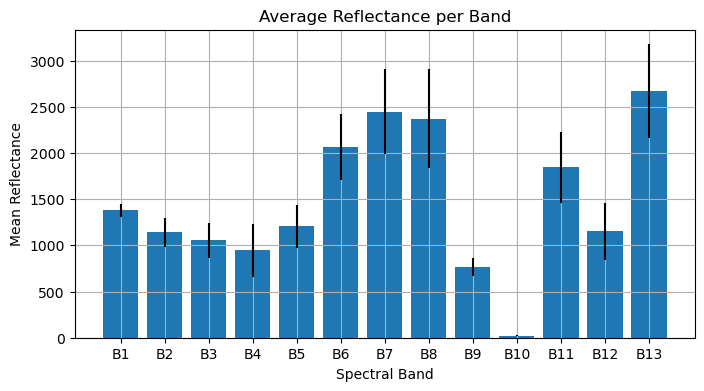

In [13]:
# ---------------------------------------------------------------
#  Dataset summary (mean & std across dataset)
# ---------------------------------------------------------------
band_means = [df_stats[f'B{i}_mean'].mean() for i in range(1, num_bands+1)]
band_stds  = [df_stats[f'B{i}_std'].mean() for i in range(1, num_bands+1)]

summary = pd.DataFrame({
    'Band': [f'B{i}' for i in range(1, num_bands+1)],
    'Mean Reflectance': band_means,
    'Std Dev Reflectance': band_stds
})
display(summary)

plt.figure(figsize=(8,4))
plt.bar(summary['Band'], summary['Mean Reflectance'], yerr=summary['Std Dev Reflectance'])
plt.title("Average Reflectance per Band")
plt.xlabel("Spectral Band")
plt.ylabel("Mean Reflectance")
plt.grid(True)
plt.show()

<Figure size 800x400 with 0 Axes>

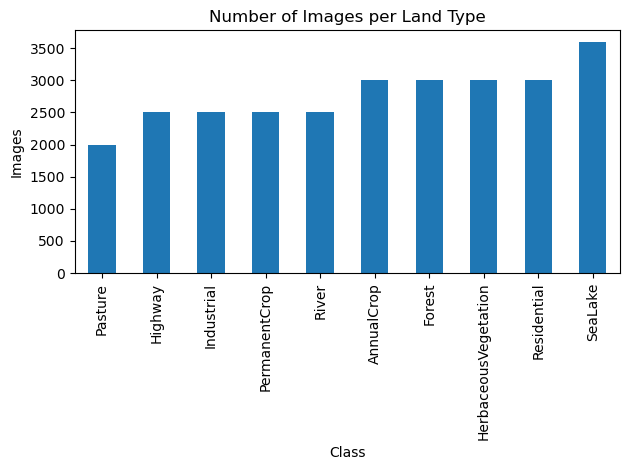

In [14]:
# ---------------------------------------------------------------
#  Class distribution visualization
# ---------------------------------------------------------------
plt.figure(figsize=(8,4))
df_counts.sort_values('num_images').plot(kind='bar', legend=False)
plt.title("Number of Images per Land Type")
plt.ylabel("Images")
plt.xlabel("Class")
plt.tight_layout()
plt.show()

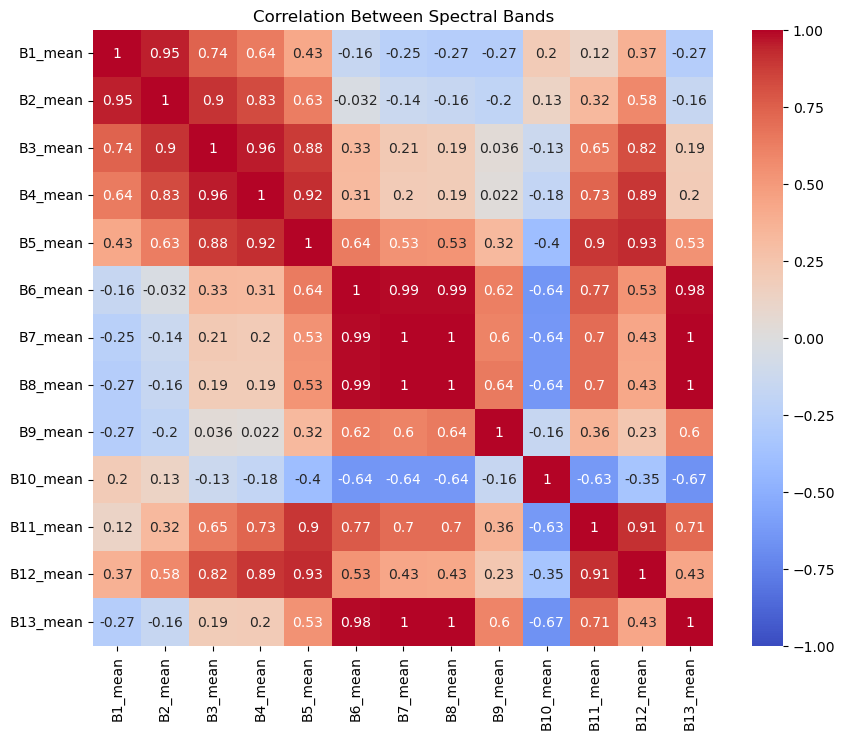

In [15]:
# ---------------------------------------------------------------
#  Correlation between bands
# ---------------------------------------------------------------
band_cols = [f'B{i}_mean' for i in range(1, num_bands+1)]
corr_matrix = df_stats[band_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Between Spectral Bands")
plt.show()


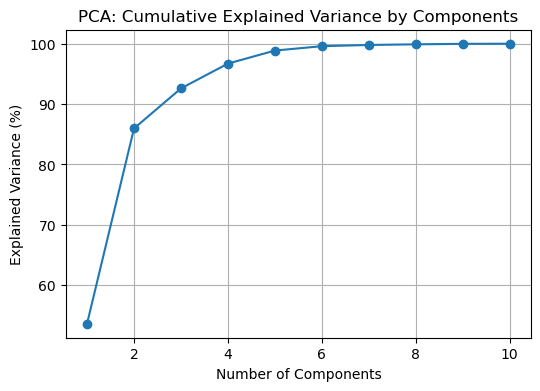

In [39]:
# ---------------------------------------------------------------
# PCA (Principal Component Analysis) for band selection insight
# ---------------------------------------------------------------
import os
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

dataset_path = r"D:\Database\EuoroSat\EuroSATallBands"  # path to multispectral EuroSAT
classes = sorted(os.listdir(dataset_path))

stats = []

for label in classes:
    folder = os.path.join(dataset_path, label)
    image_files = [f for f in os.listdir(folder) if f.endswith('.tif')]
    for f in image_files[:50]:  # sample 50 per class
        with rasterio.open(os.path.join(folder, f)) as src:
            arr = src.read().astype(float)
            # compute mean reflectance per band
            mean_bands = arr.reshape(arr.shape[0], -1).mean(axis=1)
            stats.append([label] + list(mean_bands))

columns = ['class'] + [f'B{i}' for i in range(1, arr.shape[0]+1)]
df = pd.DataFrame(stats, columns=columns)

# Compute mean per class
mean_reflectance = df.groupby('class').mean().T

X = df.drop(columns=['class'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=min(10, num_bands))
pca.fit(X_scaled)

explained = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.title("PCA: Cumulative Explained Variance by Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance (%)")
plt.grid(True)
plt.show()

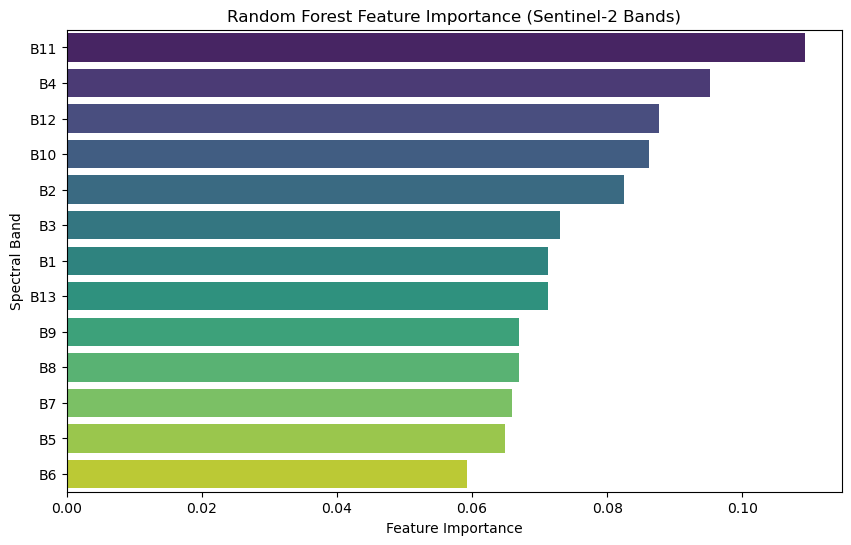


Top 5 Most Informative Bands for Land Type Classification:
   Band  Importance
10  B11    0.109228
3    B4    0.095254
11  B12    0.087705
9   B10    0.086106
1    B2    0.082470


In [40]:
# ----------------------------
#  Random Forest Feature Importance
# ----------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# Encode class labels
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances
importances = pd.DataFrame({
    'Band': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# ----------------------------
#  Plot Feature Importance
# ----------------------------
plt.figure(figsize=(10,6))
sns.barplot(data=importances, x='Importance', y='Band', palette='viridis')
plt.title('Random Forest Feature Importance (Sentinel-2 Bands)')
plt.xlabel('Feature Importance')
plt.ylabel('Spectral Band')
plt.show()

# Display Top 5 Informative Bands
print("\nTop 5 Most Informative Bands for Land Type Classification:")
print(importances.head(5))


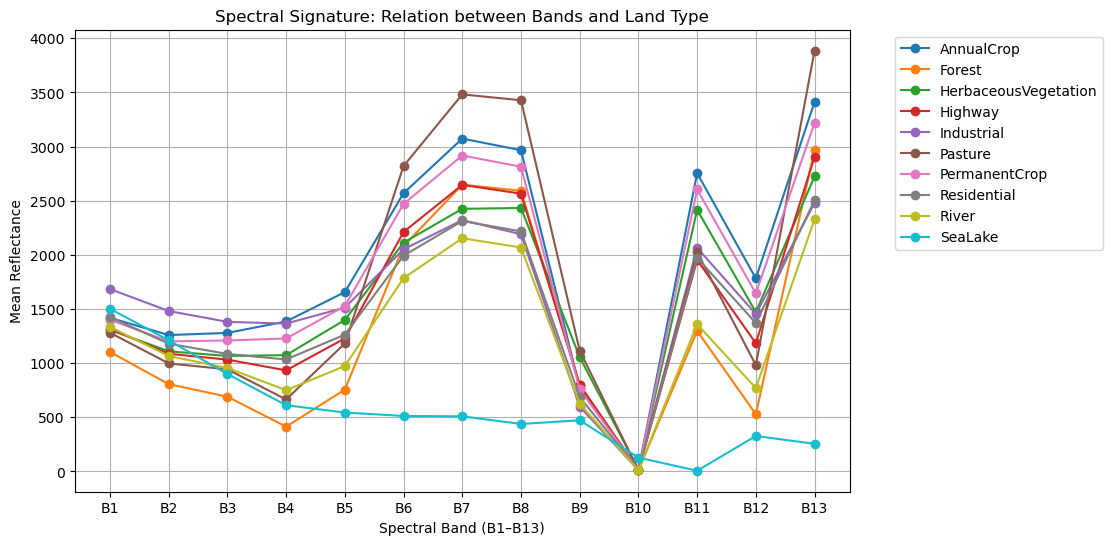

In [41]:
# Plot spectral signatures
plt.figure(figsize=(10,6))
for land_type in mean_reflectance.columns:
    plt.plot(mean_reflectance.index, mean_reflectance[land_type], marker='o', label=land_type)
plt.title("Spectral Signature: Relation between Bands and Land Type")
plt.xlabel("Spectral Band (B1–B13)")
plt.ylabel("Mean Reflectance")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


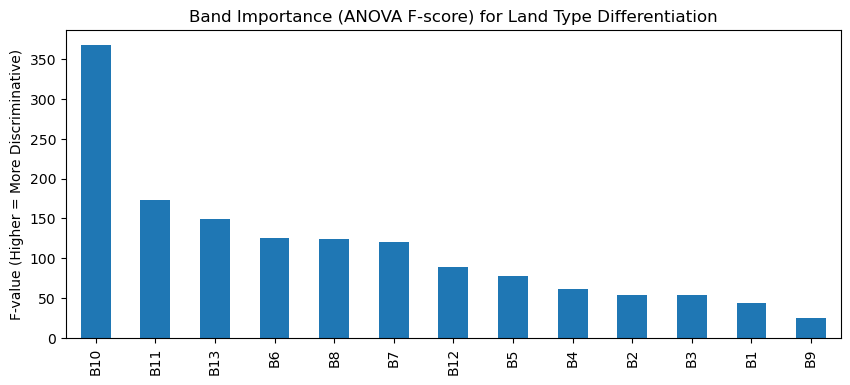

In [42]:
from sklearn.feature_selection import f_classif

X = df.drop(columns='class')
y = df['class']

f_values, p_values = f_classif(X, y)
band_importance = pd.Series(f_values, index=X.columns).sort_values(ascending=False)

band_importance.plot(kind='bar', figsize=(10,4))
plt.title("Band Importance (ANOVA F-score) for Land Type Differentiation")
plt.ylabel("F-value (Higher = More Discriminative)")
plt.show()


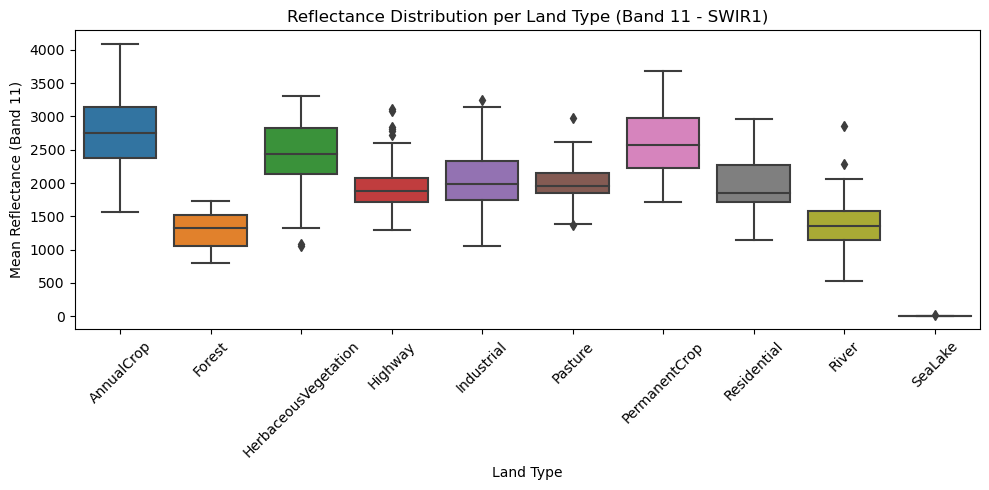

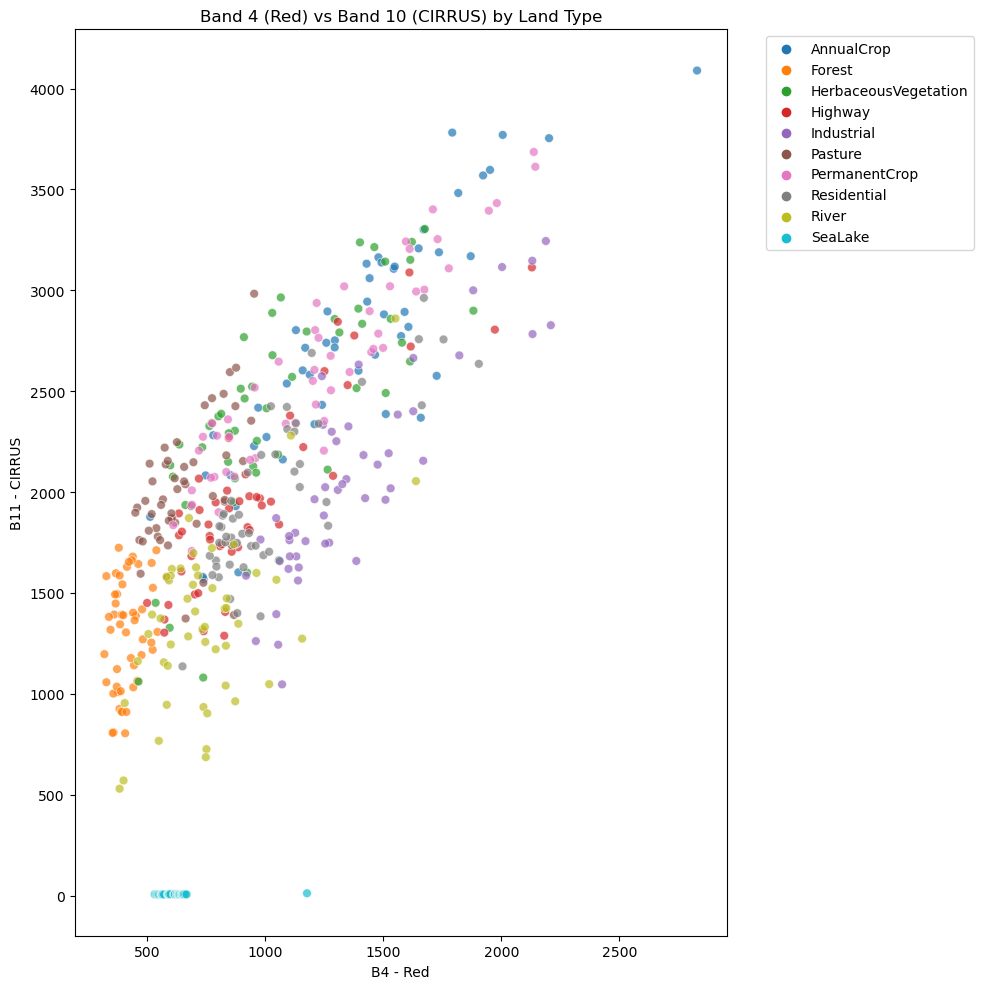

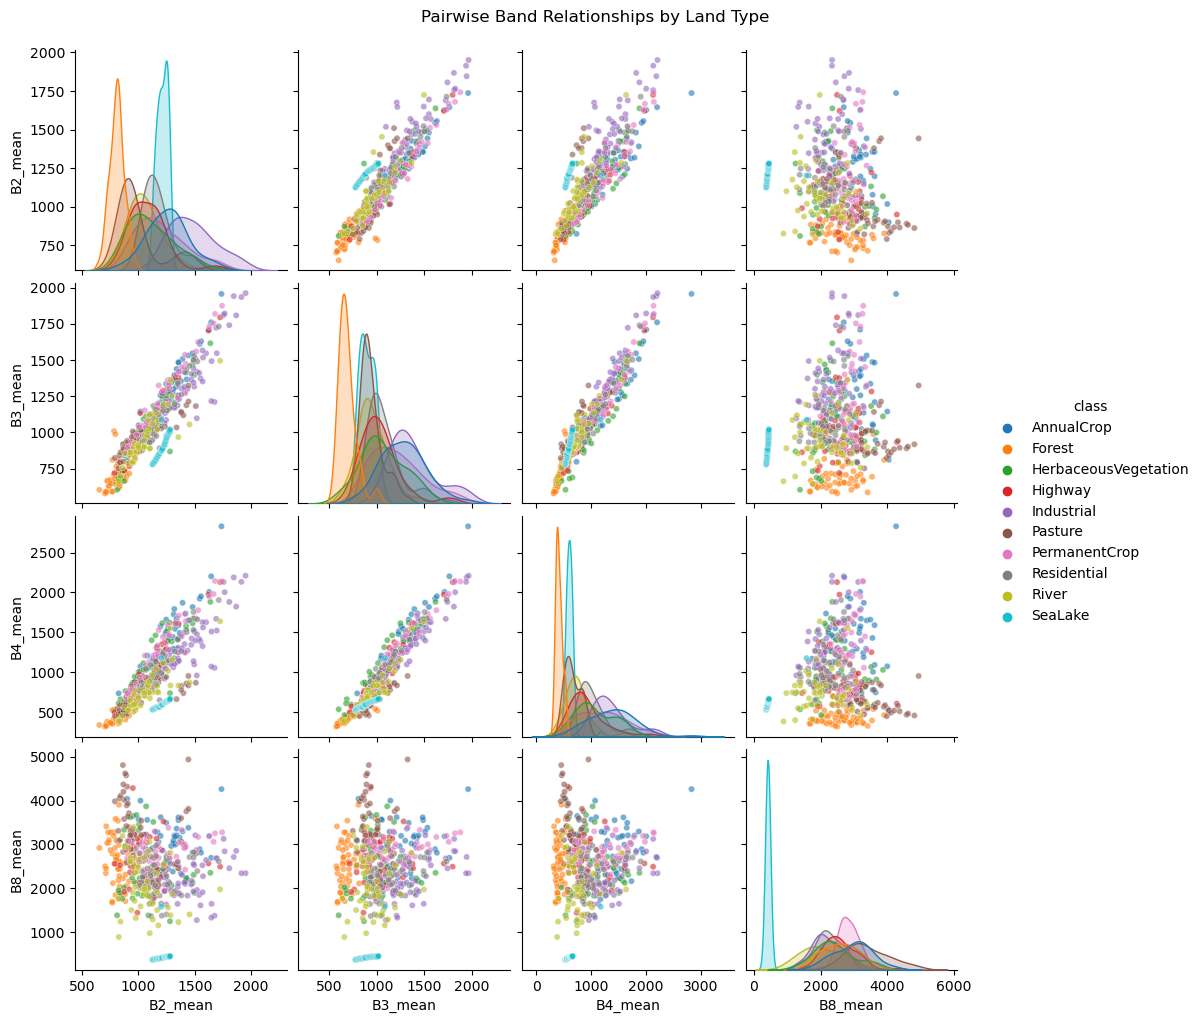

In [50]:
# ===============================================================
#  Scatter & Spectral Analysis — Band Relationships by Land Type
# ===============================================================

import seaborn as sns

# ---------------------------------------------------------------
# Boxplot — One band vs class
# ---------------------------------------------------------------
plt.figure(figsize=(10,5))
sns.boxplot(x='class', y='B11_mean', data=df_stats)
plt.xticks(rotation=45)
plt.title("Reflectance Distribution per Land Type (Band 11 - SWIR1)")
plt.ylabel("Mean Reflectance (Band 11)")
plt.xlabel("Land Type")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# Scatter between two bands (Red vs NIR)
# ---------------------------------------------------------------
plt.figure(figsize=(10,10))
sns.scatterplot(
    x='B4_mean', y='B11_mean',
    hue='class', data=df_stats,
    palette='tab10', s=40, alpha=0.7
)
plt.title("Band 4 (Red) vs Band 10 (CIRRUS) by Land Type")
plt.xlabel("B4 - Red")
plt.ylabel("B11 - CIRRUS")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# ---------------------------------------------------------------
#  Pairwise scatter plots between key bands
# ---------------------------------------------------------------
selected_bands = ['B2_mean', 'B3_mean', 'B4_mean', 'B8_mean']
sns.pairplot(df_stats, vars=selected_bands, hue='class', plot_kws={'alpha':0.6, 's':20})
plt.suptitle("Pairwise Band Relationships by Land Type", y=1.02)
plt.show()




Sample spectral indices:


,class,NDVI,NDBI,NDWI
0,AnnualCrop,0.198638,0.216480,-0.252077
1,AnnualCrop,0.576621,-0.298267,-0.555192
2,AnnualCrop,0.201589,0.104584,-0.284281
3,AnnualCrop,0.344168,-0.026257,-0.376334
4,AnnualCrop,0.403952,-0.039340,-0.409266


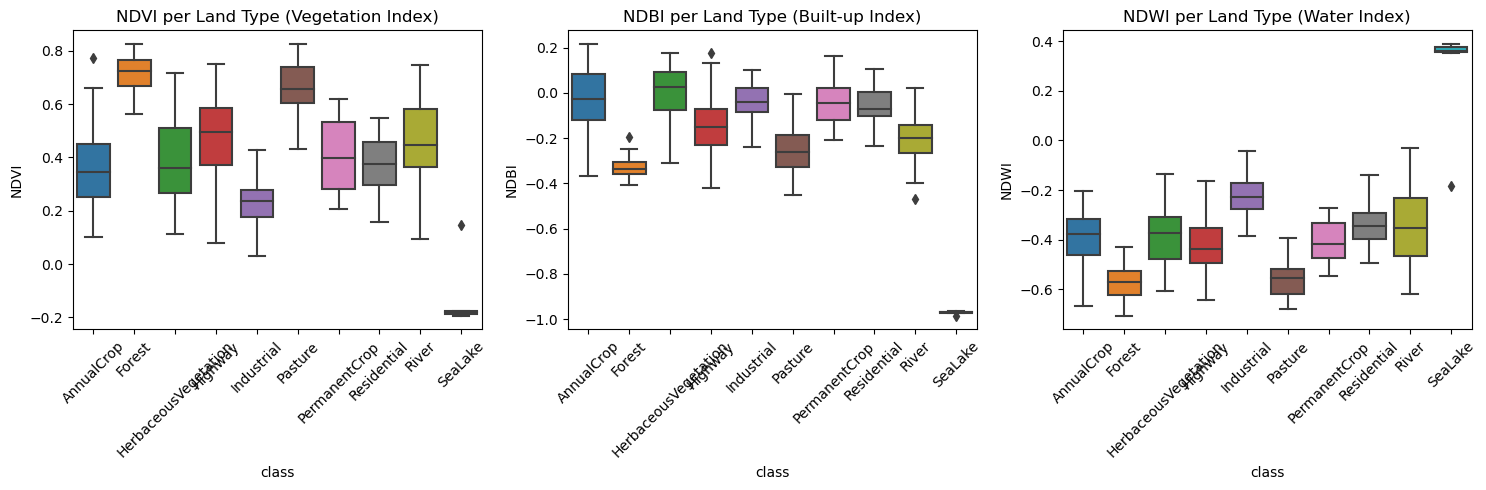

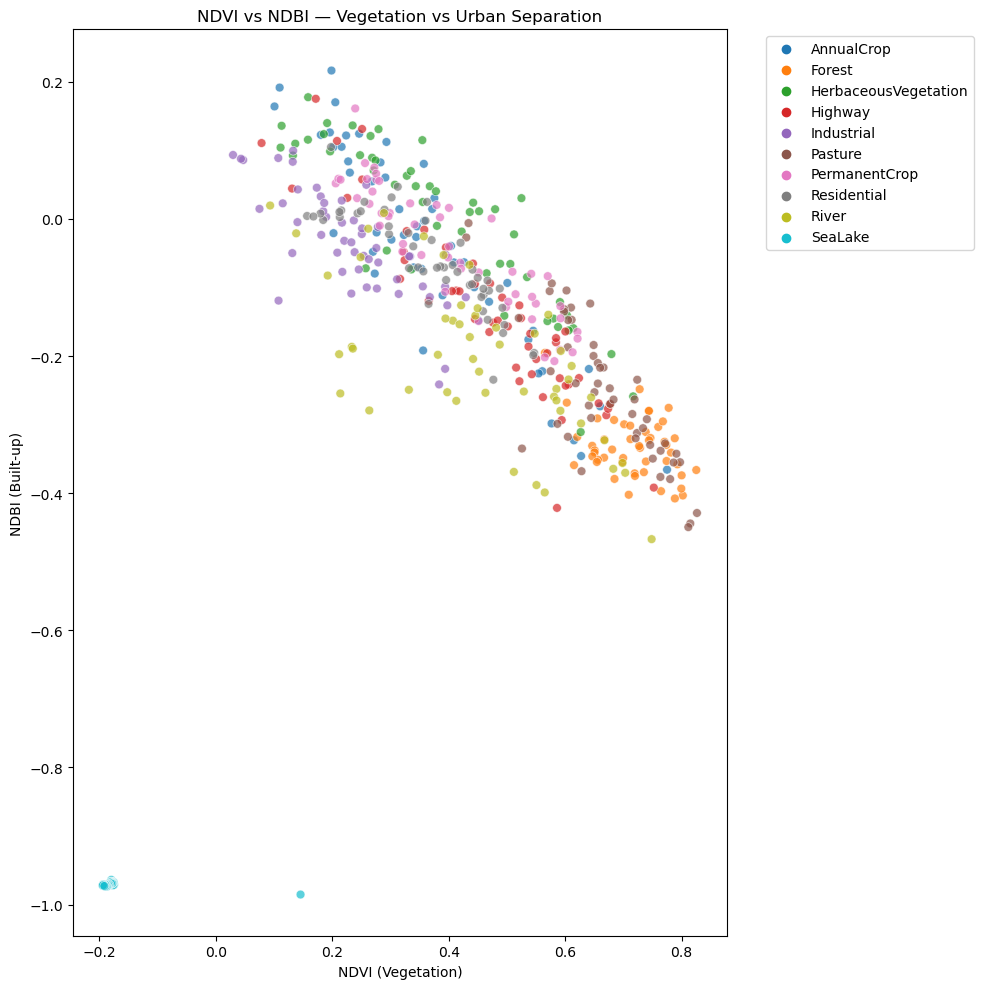

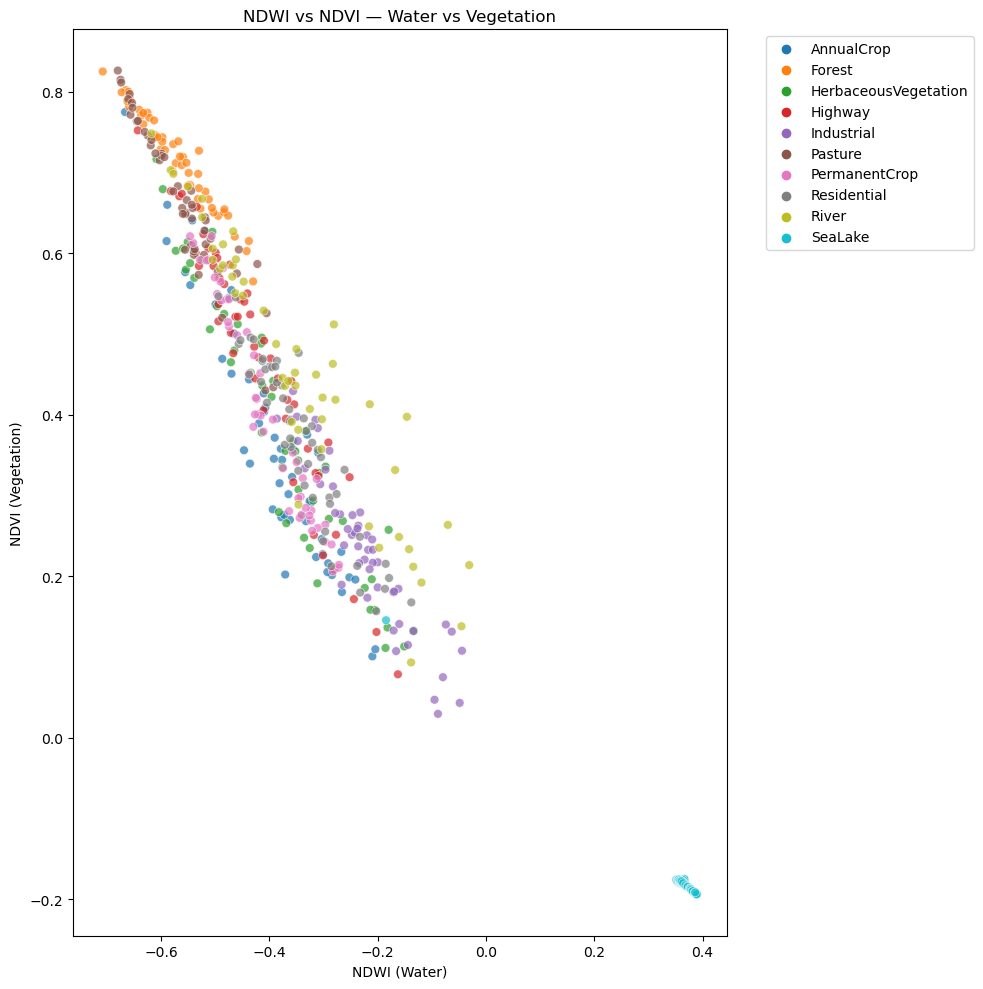

In [51]:
# ===============================================================
# 🔟 Spectral Indices (NDVI, NDBI, NDWI) — Vegetation, Urban, Water
# ===============================================================

# Check that required bands exist
required_bands = ['B3_mean', 'B4_mean', 'B8_mean', 'B11_mean']
for b in required_bands:
    if b not in df_stats.columns:
        raise ValueError(f"Missing required band: {b}")

# Compute indices for each image record
df_stats['NDVI'] = (df_stats['B8_mean'] - df_stats['B4_mean']) / (df_stats['B8_mean'] + df_stats['B4_mean'] + 1e-10)
df_stats['NDBI'] = (df_stats['B11_mean'] - df_stats['B8_mean']) / (df_stats['B11_mean'] + df_stats['B8_mean'] + 1e-10)
df_stats['NDWI'] = (df_stats['B3_mean'] - df_stats['B8_mean']) / (df_stats['B3_mean'] + df_stats['B8_mean'] + 1e-10)

print("\nSample spectral indices:")
display(df_stats[['class', 'NDVI', 'NDBI', 'NDWI']].head())

# ---------------------------------------------------------------
# (A) Boxplots of each index per land type
# ---------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x='class', y='NDVI', data=df_stats, ax=axes[0])
axes[0].set_title("NDVI per Land Type (Vegetation Index)")
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(x='class', y='NDBI', data=df_stats, ax=axes[1])
axes[1].set_title("NDBI per Land Type (Built-up Index)")
axes[1].tick_params(axis='x', rotation=45)

sns.boxplot(x='class', y='NDWI', data=df_stats, ax=axes[2])
axes[2].set_title("NDWI per Land Type (Water Index)")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# (B) Scatter relationships between indices
# ---------------------------------------------------------------
plt.figure(figsize=(10,10))
sns.scatterplot(
    data=df_stats,
    x='NDVI', y='NDBI',
    hue='class',
    palette='tab10', s=40, alpha=0.7
)
plt.title("NDVI vs NDBI — Vegetation vs Urban Separation")
plt.xlabel("NDVI (Vegetation)")
plt.ylabel("NDBI (Built-up)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
sns.scatterplot(
    data=df_stats,
    x='NDWI', y='NDVI',
    hue='class',
    palette='tab10', s=40, alpha=0.7
)
plt.title("NDWI vs NDVI — Water vs Vegetation")
plt.xlabel("NDWI (Water)")
plt.ylabel("NDVI (Vegetation)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
